In [1]:
#########################
# 5-10 December 2021    #
# Tonale Winter School  #
#########################

In [2]:
#Python Notebook written by Marta Spinelli
#Acknowledgements: Siyambonga Mashawule

2$^{nd}$ PART

In [4]:
import numpy as np
import healpy as hp
from astropy.io import fits
import scipy.ndimage as ndimage
from sklearn.decomposition import FastICA
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### To properly construct a mock 21cm IM observation we need to take into account the effect of the instrument

### We will consoder 2 main effects:
1. The primary beam
2. The telescope thermal noise

#### Lets' first input again our frequency range and patch used in PART ONE

In [5]:
def plot_patch(patch,label,title,extent):

    fig, ax = plt.subplots()
    norm=plt.Normalize(vmin=np.min(patch), vmax=np.max(patch))
    ax = plt.gca()
    im = ax.imshow(patch.T,extent=extent,norm=norm,origin='lower')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax,label=label)


    ax.set_xlabel(r'${\rm R.A} (J2000) [^\circ]$',fontsize=15)
    ax.set_ylabel(r'${\rm Dec} (J2000) [^\circ]$',fontsize=15)
    fig.tight_layout()

In [13]:
def f2z(f):
    #input freq in MHz
    #1+z =fe/fo
    return 1420./f-1

In [14]:
fmin=850.
fmax=949.
Df=1. 
zmin=f2z(fmax)
zmax=f2z(fmin)
print(zmin, zmax)

0.4963119072708113 0.6705882352941177


In [11]:
freqs=np.arange(fmin,fmax+Df,Df)
Nf=len(freqs)

In [12]:
ra=np.load('output/MK_footprint.npz')['ra']
dec=np.load('output/MK_footprint.npz')['dec']
ra_edges=np.load('output/MK_footprint.npz')['ra_edges']
dec_edges=np.load('output/MK_footprint.npz')['dec_edges']

#for plots
extent=[np.min(ra),np.max(ra),np.min(dec),np.max(dec)]

####  and the signal and fg data cubes constructed

In [9]:
cube_synch=np.load('output/cube_patch_synch.npz')['cube_patch']
cube_ff=np.load('output/cube_patch_ff.npz')['cube_patch']
cube_ps=np.load('output/cube_patch_ps.npz')['cube_patch']


cube_HI=np.load('input/HI_cube.npz')['cube_HI']

Choose a LOS and plot the various ingredients

Text(0.5, 0, '$\\nu\\: ({\\rm MHz})$')

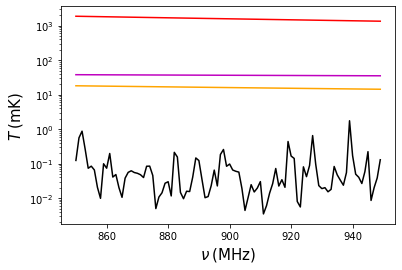

In [15]:
px=50
py=40

plt.plot(freqs,cube_synch[px,py,:]*1e3,label=r'$Synch$',color='r')
plt.plot(freqs,cube_ff[px,py,:]*1e3,label=r'$Free-Free$',color='orange')
plt.plot(freqs,cube_ps[px,py,:]*1e3,label=r'$PS$',color='m')

plt.plot(freqs,cube_HI[px,py,:],label=r'$HI$',color='k')


plt.yscale('log')
plt.ylabel(r'$T\: ({\rm mK})$',fontsize=15)
plt.xlabel(r'$\nu\: ({\rm MHz})$',fontsize=15)

### Now we assemple all the components

In [17]:
final_sky=cube_synch+cube_ff+cube_ps+cube_HI/1e3 #K

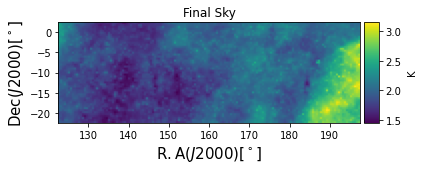

In [18]:
plot_patch(final_sky[:,:,10],r'${\rm K}$','Final Sky',extent)

### We now introduce the smoothing due to the beam (in a simplified way)

In [19]:
#the resolution of a single dish telescope is lambda/D
#where D is the diameter of the dish.
#We will work in the simplied assumption of a constant beam, using the central frequency of our band.
D=13.5 #in m
c=299792458. #m/s
lam=c/((900.)*1e6)
print('lambda: ',lam)
print('resolution: ',lam/D*180/np.pi, '(deg)')

lambda:  0.3331027311111111
resolution:  1.413731899033168 (deg)


In [20]:
res=lam/D*180/np.pi

Now we apply the Gaussian beam

In [21]:
beam_sky = ndimage.gaussian_filter(final_sky, sigma=(res,res,0), order=0)

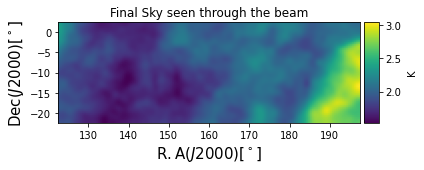

In [22]:
plot_patch(beam_sky[:,:,10],r'${\rm K}$','Final Sky seen through the beam',extent)

### Finally the telescope thermal noise

To compute the noise:
$ \sigma_N = T_{sys}/\sqrt{(2 t_{pix} \delta \nu})$
with $t_{pix}=(t_{obs}N_{dish})/N_{pix}$

In [23]:
Tsys=10*1e3 #mK
Ndish=64 
tobs=10000 #in hours
Nx=151
Ny=51
Npix=Nx*Ny

In [24]:
tpix=tobs*3600*Ndish/Npix
sigma_N=Tsys/np.sqrt(2*tpix*1e6)
print(sigma_N) #in mk

0.012927582752909892


(array([1.05000e+02, 3.05000e+03, 3.00760e+04, 1.34791e+05, 2.64190e+05,
        2.31249e+05, 9.03450e+04, 1.50940e+04, 1.16500e+03, 3.50000e+01]),
 array([-0.05843933, -0.04636063, -0.03428194, -0.02220325, -0.01012455,
         0.00195414,  0.01403283,  0.02611153,  0.03819022,  0.05026891,
         0.06234761]),
 <a list of 10 Patch objects>)

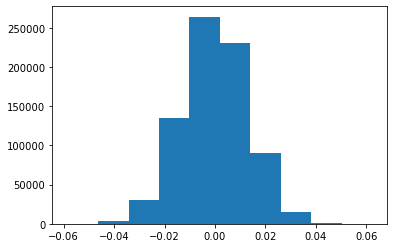

In [25]:
seed=1111
np.random.seed(seed)
cube_noise=np.random.normal(0,sigma_N, Nx*Ny*Nf).reshape((Nx,Ny,Nf))
plt.hist(cube_noise.flatten(),bins=10)

Text(0.5, 0, '$\\nu\\: ({\\rm MHz})$')

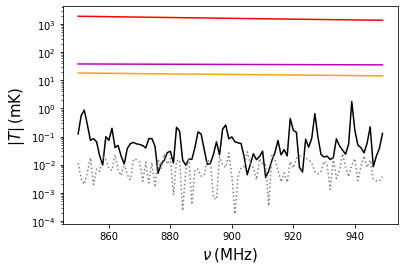

In [26]:
px=50
py=40

plt.plot(freqs,cube_synch[px,py,:]*1e3,label=r'$Synch$',color='r')
plt.plot(freqs,cube_ff[px,py,:]*1e3,label=r'$Free-Free$',color='orange')
plt.plot(freqs,cube_ps[px,py,:]*1e3,label=r'$PS$',color='m')

plt.plot(freqs,cube_HI[px,py,:],label=r'$HI$',color='k')
plt.plot(freqs,np.abs(cube_noise[px,py,:]),label=r'$noise$',color='grey',linestyle=':')

plt.yscale('log')
plt.ylabel(r'$|T|\: ({\rm mK})$',fontsize=15)
plt.xlabel(r'$\nu\: ({\rm MHz})$',fontsize=15)

## The final mock observation!

In [27]:
mock21=beam_sky+cube_noise/1e3 #all units in K

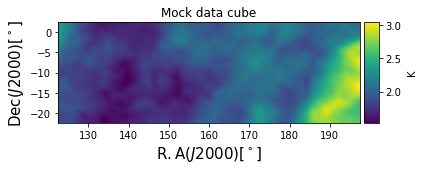

In [28]:
plot_patch(mock21[:,:,10],r'${\rm K}$','Mock data cube',extent)

In [29]:
np.savez('output/final_mock21.npz',mock21=mock21,freqs=freqs)

### Let's save the signal +noise version too, to check for foreground cleaning

We need to convolve with the beam and add noise

In [30]:
beam_HI = ndimage.gaussian_filter(cube_HI, sigma=(res,res,0), order=0)

In [31]:
sig_noise=(beam_HI+cube_noise)/1e3 #all units now in K

In [32]:
np.savez('output/sig_noise.npz',sig_noise=sig_noise)

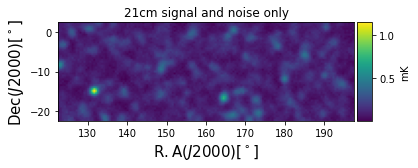

In [33]:
plot_patch(sig_noise[:,:,10]*1e3,r'${\rm mK}$','21cm signal and noise only',extent)

In [34]:
sig_noise=cube_noise/1e3 #all units now in K
np.savez('output/noise_only.npz',noise=cube_noise)

In [35]:
sig_only=beam_HI/1e3 #all units now in K
np.savez('output/sig_only.npz',signal=sig_only)